# Read benchmarks datas

In [8]:
# devices = {'GTX1080Ti': {'Hash-Mode 0': 34949000000, ...} ...}
import os
import re
import humanize

devices = {}

benchmarks_dir = 'benchmarks'
for filename in os.listdir(benchmarks_dir):
    if filename.endswith('.txt'):
        device_name = filename.replace('.txt', '')
        devices[device_name] = {}
        with open(os.path.join(benchmarks_dir, filename), encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        current_hashmode = None
        for line in lines:
            # Match Hashmode行（etc: Hashmode: 0 - MD5 or * Hash-Mode 0 (MD5)）
            m1 = re.match(r'Hashmode:\s*([\d]+)\s*-\s*(.+)', line)
            m2 = re.match(r'\* Hash-Mode\s*([\d]+)\s*\((.+?)\)', line)
            if m1:
                hashmode_id = m1.group(1)
                hashmode_name = m1.group(2).strip()
                current_hashmode = f'Hash-Mode {hashmode_id}'
            elif m2:
                hashmode_id = m2.group(1)
                hashmode_name = m2.group(2).strip()
                current_hashmode = f'Hash-Mode {hashmode_id}'
            # Match Speed
            speed_match = re.search(r'Speed\.(?:Dev\.#\d+|#\d+|#\*)\.*:\s*([0-9\.\,]+)\s*([kMGT]?H/s)', line)
            if current_hashmode and speed_match:
                speed_value = speed_match.group(1).replace(',', '')
                speed_unit = speed_match.group(2)
                # Unit H/s
                unit_map = {'H/s': 1, 'kH/s': 1e3, 'MH/s': 1e6, 'GH/s': 1e9, 'TH/s': 1e12}
                speed = float(speed_value) * unit_map.get(speed_unit, 1)
                # Just first device, ignore other devices
                if current_hashmode not in devices[device_name]:
                    devices[device_name][current_hashmode] = speed

# Check parse devices
print("Detect devices:", len(devices))
for device, hashmode_data in devices.items():
    hashmode = 'Hash-Mode 0'
    if hashmode in hashmode_data:
        human_readable_speed = humanize.naturalsize(hashmode_data[hashmode])
    else:
        human_readable_speed = 0
    # device name default 10 chars
    device_name = device[:10]
    if len(device_name) < 10:
        device_name = device_name + ' ' * (10 - len(device_name))
    print(f"{device_name} \t-> {hashmode}: {human_readable_speed}")



Detect devices: 17
CMP50HX    	-> Hash-Mode 0: 42.7 GB
GTX1070    	-> Hash-Mode 0: 18.6 GB
GTX1080Ti  	-> Hash-Mode 0: 35.2 GB
H100PCIE   	-> Hash-Mode 0: 87.5 GB
P104       	-> Hash-Mode 0: 16.8 GB
P106       	-> Hash-Mode 0: 9.5 GB
RTX2080    	-> Hash-Mode 0: 37.1 GB
RTX2080Ti  	-> Hash-Mode 0: 50.7 GB
RTX3080    	-> Hash-Mode 0: 54.0 GB
RTX3090    	-> Hash-Mode 0: 65.1 GB
RTX4080    	-> Hash-Mode 0: 98.3 GB
RTX4090    	-> Hash-Mode 0: 164.1 GB
RTX5070Ti  	-> Hash-Mode 0: 88.2 GB
RTX5080    	-> Hash-Mode 0: 104.8 GB
RTX5090    	-> Hash-Mode 0: 220.6 GB
RTXTITAN   	-> Hash-Mode 0: 64.0 GB
TESLA_A100 	-> Hash-Mode 0: 64.9 GB


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import re, os

def draw_chart(hashmode):
    # Extra device name and Hash-Mode 0 speed
    device_names = []
    speeds = []
    for device, hashmode_data in devices.items():
        if hashmode in hashmode_data:
            device_names.append(device)
            if hashmode in hashmode_data:
                speeds.append(hashmode_data[hashmode])

    # best performance in first
    sorted_data = sorted(zip(speeds, device_names), reverse=False)
    sorted_speeds, sorted_device_names = zip(*sorted_data)

    # draw view
    fig_height = max(8, len(sorted_device_names) * 0.6)  # auto height
    plt.figure(figsize=(12, fig_height))
    
    # create bar image
    y_pos = np.arange(len(sorted_device_names))
    bars = plt.barh(y_pos, sorted_speeds, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # add tag
    for i, (bar, speed) in enumerate(zip(bars, sorted_speeds)):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                humanize.naturalsize(speed), 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # add value
    plt.yticks(y_pos, sorted_device_names)
    plt.xlabel(f'{hashmode} Speed (H/s)')
    plt.title(f'Device for {hashmode} Speed', fontsize=14, fontweight='bold')
    
    # add grid net
    plt.grid(True, axis='x', alpha=0.3)
    
    # ajustive layout
    plt.tight_layout()

    # save image to images hashmode-xxx.png
    # Save the image to the images directory, filename as xxx.png
    if not os.path.exists('images'):
        os.makedirs('images')
    safe_hashmode = re.sub(r'[^a-zA-Z0-9]+', '_', hashmode)
    filename = f'images/{safe_hashmode}.png'
    plt.savefig(filename, dpi=150)
    print(f"Image saved to: {filename}")

    # show image
    plt.show()
    


Image saved to: images/Hash_Mode_0.png


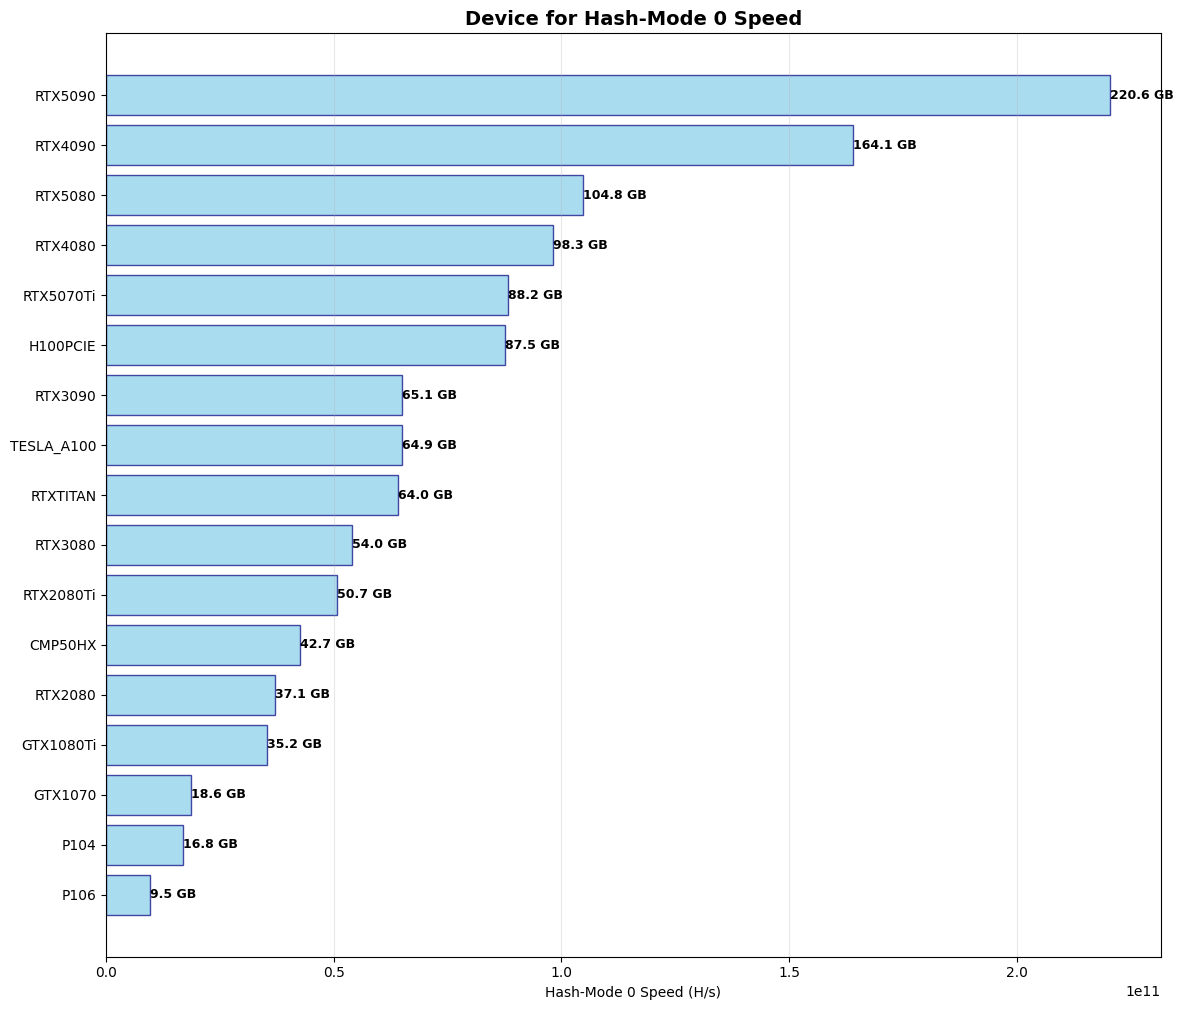

In [12]:
draw_line_chart('Hash-Mode 2500', 'Hash-Mode 22000')
draw_line_chart('Hash-Mode 0', None)
draw_line_chart('Hash-Mode 22100', None)